# Part 1: Neural Networks Basics

## Introduction

In this part, you'll implement a simple neural network for EMNIST character recognition. This will help you understand the fundamentals of neural networks, including dense layers, activation functions, and dropout.

## Learning Objectives

- Load and preprocess EMNIST dataset
- Implement a simple neural network with dense layers
- Train and evaluate the model
- Save model and metrics in the correct format

## Setup and Installation

In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_1', exist_ok=True)
os.makedirs('logs', exist_ok=True)

2025-05-13 23:47:56.946883: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 23:47:56.962816: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 23:47:56.996950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747205277.035645  120671 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747205277.048631  120671 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747205277.111859  120671 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## 1. Data Loading and Preprocessing

In [2]:
import tensorflow_datasets as tfds
(dat_train, dat_test), ds_info = tfds.load(
  'mnist',
  split=['train', 'test'],
  shuffle_files=True,
  as_supervised=True,
  with_info=True,
)

x_train = []
y_train = []
for image, label in tfds.as_numpy(dat_train):
    x_train.append(image)
    y_train.append(label)

x_test = []
y_test = []
for image, label in tfds.as_numpy(dat_test):
    x_test.append(image)
    y_test.append(label)


E0000 00:00:1747205282.305135  120671 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1747205282.309872  120671 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-05-13 23:48:02.443315: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-05-13 23:48:15.241354: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-13 23:48:17.136630: I tensorflow/core/framework/

Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)
Number of classes: 10


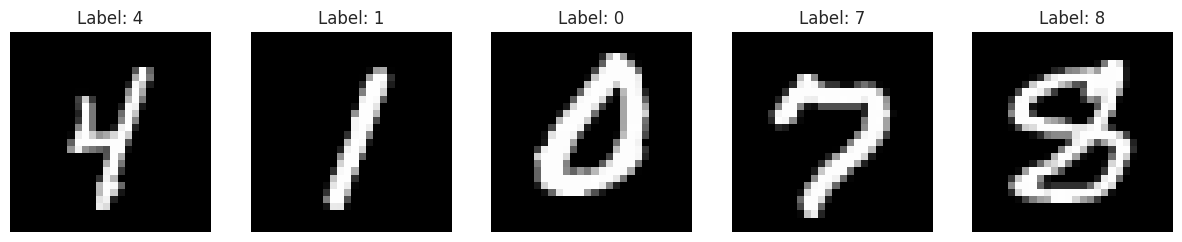

In [3]:
x_train = np.squeeze(np.array(x_train))
y_train = np.squeeze(np.array(y_train))
x_test = np.squeeze(np.array(x_test))
y_test = np.squeeze(np.array(y_test))
# without squeeze, there is an extra dimension of 1

# Print dataset information
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

# Plot sample images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')
plt.show()

In [4]:
# Preprocess data
# Normalize pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0

# Reshape for dense layers
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes=10)

# Split training data into train and validation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print(f"Preprocessed training data shape: {x_train.shape}")
print(f"Preprocessed validation data shape: {x_val.shape}")
print(f"Preprocessed test data shape: {x_test.shape}")

Preprocessed training data shape: (48000, 784)
Preprocessed validation data shape: (12000, 784)
Preprocessed test data shape: (10000, 784)


## 2. Model Implementation

In [5]:
# Create simple neural network
def create_simple_nn(input_shape, num_classes):
    """
    Create a simple neural network for EMNIST classification.
    
    Requirements:
    - Must use at least 2 dense layers
    - Must include dropout layers
    - Must use categorical crossentropy loss
    
    Goals:
    - Achieve > 80% accuracy on test set
    - Minimize overfitting using dropout
    - Train efficiently with appropriate batch size
    
    Args:
        input_shape: Shape of input data (should be (784,) for flattened 28x28 images)
        num_classes: Number of output classes (26 for letters)
        # will be using 10 for nmist digits
    
    Returns:
        Compiled Keras model
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

# Create and compile model
model = create_simple_nn(input_shape=(784,), num_classes=10) # num_classes changed for digits
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,650 (205.66 KB)

 Trainable params: 52,650 (205.66 KB)

 Non-trainable params: 0 (0.00 B)

## 3. Training and Evaluation

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7038 - loss: 0.9124 - val_accuracy: 0.9314 - val_loss: 0.2403 - learning_rate: 0.0010
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9003 - loss: 0.3463 - val_accuracy: 0.9459 - val_loss: 0.1974 - learning_rate: 0.0010
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9209 - loss: 0.2786 - val_accuracy: 0.9505 - val_loss: 0.1732 - learning_rate: 0.0010
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9277 - loss: 0.2522 - val_accuracy: 0.9572 - val_loss: 0.1588 - learning_rate: 0.0010
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9344 - loss: 0.2291 - val_accuracy: 0.9602 - val_loss: 0.1441 - learning_rate: 0.0010
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9399 - loss: 0.2090 - val_accuracy: 0.9617 - val_loss: 0.1421 - learning_rate: 0.0010
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9441 - l

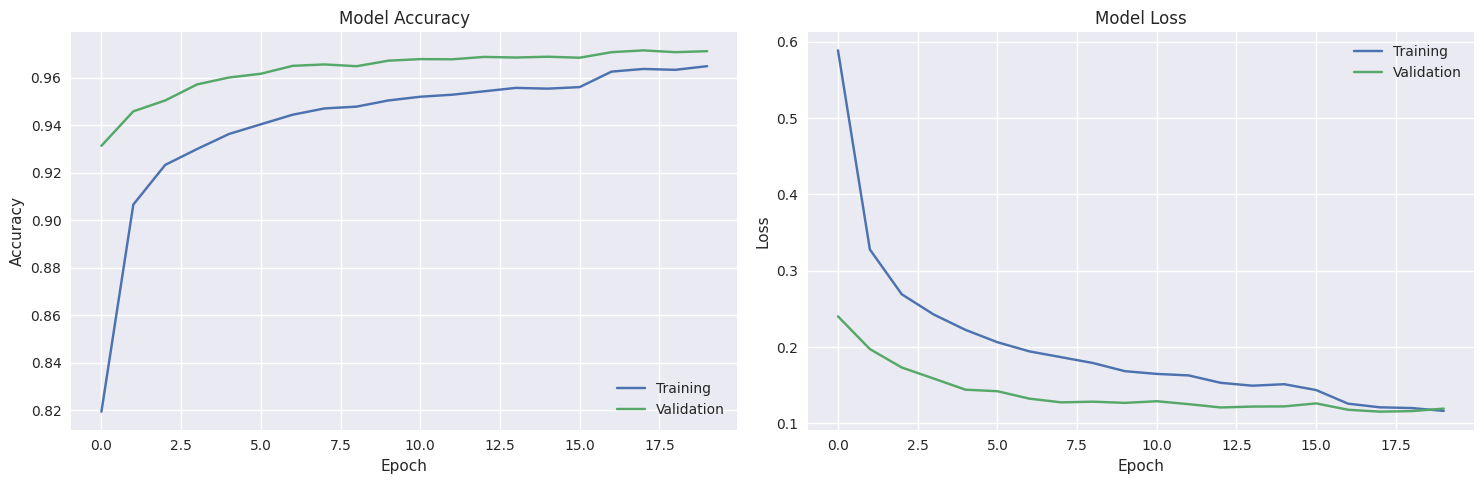

In [6]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/emnist_classifier.keras',
        save_best_only=True
    )
]

# Train model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9693 - loss: 0.1136
Test accuracy: 0.9698
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step


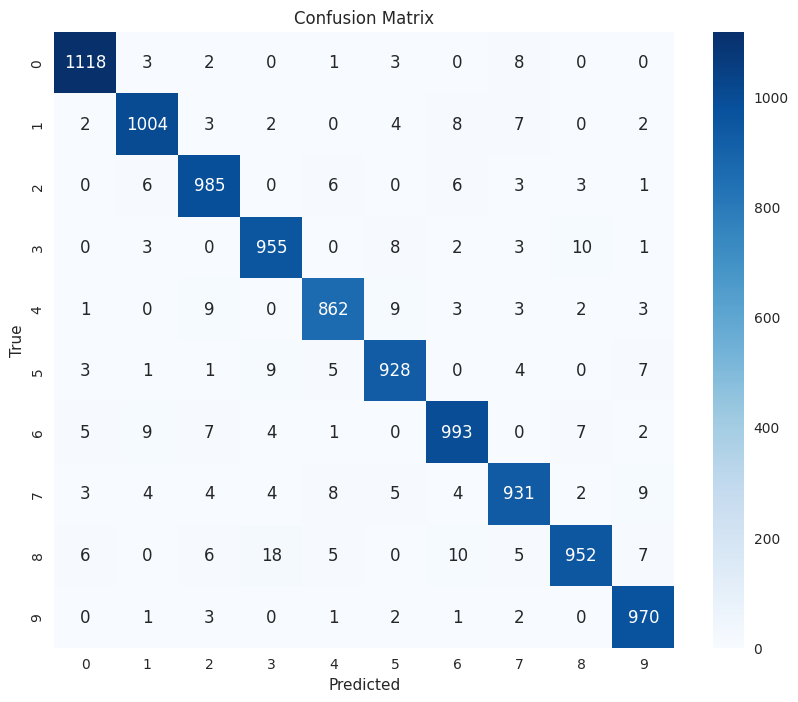

In [8]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Get predictions
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Calculate confusion matrix
cm = tf.math.confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save metrics
metrics = {
    'model': 'nmist_classifier',
    'accuracy': float(test_accuracy),
}

# Save to file
with open('results/part_1/emnist_classifier_metrics.txt', 'w') as f:
    f.write(f"model: {metrics['model']}\n")
    f.write(f"accuracy: {metrics['accuracy']}\n")
    f.write("----\n")